In [1]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2024-04-23 15:12:37.709916: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 15:12:37.726181: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 15:12:37.841196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 15:12:37.841255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 15:12:37.869418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0


In [2]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Datasets/dataset_reduced.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (602649, 19)


,turbine,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,grid_frecuency,grid_voltage,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,R80736,16.480000,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,50.000000,708.53003,1.801180,29.480000,222.05,222.05,10823.5,2043069.9
602645,R80736,16.740000,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,49.990002,714.59998,1.798038,29.379999,221.98,221.98,10843.5,2043060.1
602646,R80736,17.370001,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,49.980000,710.71002,1.801180,32.730000,203.55,203.55,10853.3,2048070.1
602647,R80711,16.820000,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,50.000000,708.29999,1.801180,26.010000,237.59,237.59,10817.3,2041980.0
602648,R80736,17.610001,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,50.000000,710.89001,1.799085,27.200001,219.62,219.62,10837.3,2043120.0


In [3]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine                0
theta                  0
hub_temperature        0
nacelle_angle          0
nacelle_temperature    0
V1                     0
V2                     0
V                      0
Wind_angle             0
Vane_angle             0
Out_temperature        0
grid_frecuency         0
grid_voltage           0
W                      0
Rotor_temperature      0
Wind_angle_c           0
nacelle_angle_c        0
T                      0
P                      0
dtype: int64


In [4]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,grid_frecuency,grid_voltage,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,16.480000,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,50.000000,708.53003,1.801180,29.480000,222.05,222.05,10823.5,2043069.9
602645,16.740000,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,49.990002,714.59998,1.798038,29.379999,221.98,221.98,10843.5,2043060.1
602646,17.370001,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,49.980000,710.71002,1.801180,32.730000,203.55,203.55,10853.3,2048070.1
602647,16.820000,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,50.000000,708.29999,1.801180,26.010000,237.59,237.59,10817.3,2041980.0
602648,17.610001,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,50.000000,710.89001,1.799085,27.200001,219.62,219.62,10837.3,2043120.0


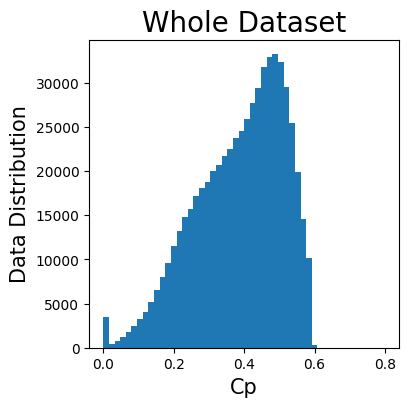

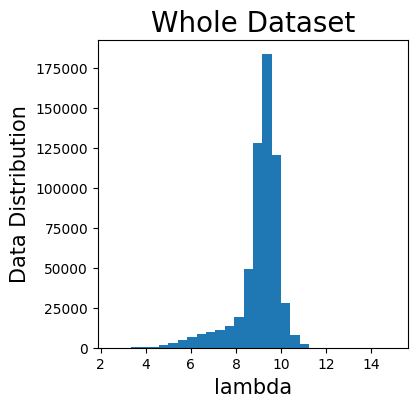

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,grid_frecuency,grid_voltage,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P,Cp,lambda
602644,16.480000,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,50.000000,708.53003,1.801180,29.480000,222.05,222.05,10823.5,2043069.9,0.079908,3.707248
602645,16.740000,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,49.990002,714.59998,1.798038,29.379999,221.98,221.98,10843.5,2043060.1,0.078364,3.676787
602646,17.370001,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,49.980000,710.71002,1.801180,32.730000,203.55,203.55,10853.3,2048070.1,0.073819,3.607639
602647,16.820000,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,50.000000,708.29999,1.801180,26.010000,237.59,237.59,10817.3,2041980.0,0.073492,3.605878
602648,17.610001,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,50.000000,710.89001,1.799085,27.200001,219.62,219.62,10837.3,2043120.0,0.073318,3.598171


In [5]:
# Add Cp and lambda to the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

Cp_data = Cp_fromP(dataset['P'][:],dataset['V'][:])
dataset['Cp'] = Cp_data
lambd_data = lambd(dataset['V'][:], dataset['W'][:])
dataset['lambda'] = lambd_data

plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

dataset.tail()

In [6]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-0.081045,5.978549,-1.08,-1.000000,-0.990000,-0.900000,9.276000e+01
hub_temperature,602649.0,19.060174,5.838598,4.05,14.170000,18.719999,23.000000,3.900000e+01
nacelle_angle,602649.0,180.414785,92.988829,0.00,102.290000,200.679990,246.100010,3.600000e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.49,20.639999,25.110001,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.00,4.950000,5.870000,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.00,4.990000,5.900000,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,0.23,4.970000,5.890000,7.130000,2.050000e+01
Wind_angle,602649.0,180.053769,92.830444,0.00,102.270000,199.610000,245.160000,3.600000e+02
Vane_angle,602649.0,-0.184985,9.427393,-179.34,-5.310000,-0.460000,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.95,5.960000,10.910000,16.330000,3.828000e+01


In [7]:
# Normalization 
# Cp in the range [0,1]. Originally, it was in [0,Cp_max]
# Rest of the variables with mean 0 and std 1

print(dataset.describe().transpose()[['mean', 'std']])

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )

column_name = dataset.columns.values
Cp_column = column_name[5]
#print(Cp_column)

Cp_max = 0.5926
dataset_norm = dataset.copy()
icol = 0
for col in column_name:
    if(col!='Cp'): # mean 0 and std 1
        dataset_norm[col]=(dataset[col]-x_mean[icol])/x_std[icol]        
    else: # Cp in [0,1]
        dataset_norm[col]=dataset[col]/Cp_max
    icol = icol+1

print()
print("Normalized dataset")
print(dataset_norm.describe().transpose()[['mean', 'std']])

                              mean            std
theta                    -0.081045       5.978549
hub_temperature          19.060174       5.838598
nacelle_angle           180.414785      92.988829
nacelle_temperature      24.595032       6.192875
V1                        6.306669       2.018830
V2                        6.321526       1.956744
V                         6.314169       1.982688
Wind_angle              180.053769      92.830444
Vane_angle               -0.184985       9.427393
Out_temperature          11.473260       7.091906
grid_frecuency           49.989283       0.418907
grid_voltage            700.354780       7.255057
W                         1.362470       0.318853
Rotor_temperature        28.486577       4.714501
Wind_angle_c            179.627065      92.421807
nacelle_angle_c         179.767785      92.504951
T                      2646.532389    2258.267705
P                    444860.879260  446349.165241
Cp                        0.386876       0.124435


In [8]:
# load model 1
model1 = tf.keras.models.load_model('../Models/Cp3D_sigmoid_model.h5')
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               512       
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17153 (67.00 KB)
Trainable params: 17153 (67.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-04-23 15:13:15.469056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 15:13:15.487581: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
# load model 2
model2 = tf.keras.models.load_model('../Models/Pres_hybrid.h5')
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2176      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18817 (73.50 KB)
Trainable params: 18817 (73.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 1)                    17153     ['input_1[0][0]']             
                                                                                                  
 sequential (Sequential)     (None, 1)                    18817     ['input_2[0][0]']             
                                                                                              

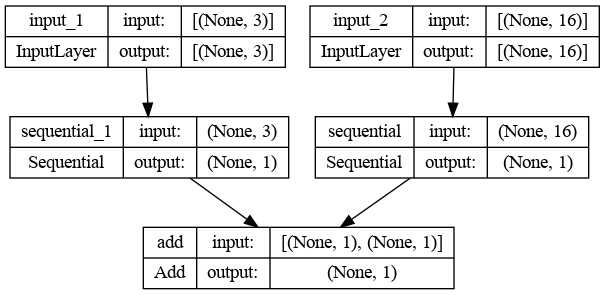

In [10]:
# Global model as model1 + model2 

input1 = tf.keras.Input(shape=(3,))
input2 = tf.keras.Input(shape=(16,))

output1 = model1(input1) 
output2 = model2(input2)

# NORMALIZATION OF EACH MODEL HERE

# Global model
global_output = tf.keras.layers.Add()([output1, output2])

model = tf.keras.Model(inputs=[input1,input2],outputs=global_output)
model.summary()
tf.keras.utils.plot_model(model, "../Models/Global_model.png", show_shapes=True)

In [13]:
# Define input features to calculate P_phys
dataset_copy = dataset_norm.copy()
xphys = dataset_copy[['V','theta','W']]

# Evaluate Cp model on data
Cp_pred = model1.predict(xphys[['V','theta','W']]).flatten()

# Calculate P_phys from the prediction of Cp
def P_fromCp(Cp, Vw):
    Pturbina = 0.5 * Cp * const.rho * const.A * Vw**3
    return Pturbina

Cp_pred = Cp_pred * Cp_max  # convert Cp to original units
V_true = dataset.loc[:,'V'] # V in original units
V_true = V_true.to_numpy()
P_phys = P_fromCp(Cp_pred,V_true)  # calculate Power in original units

# Add power to the dataset
dataset['P_phys'] = P_phys
dataset.describe().transpose()
#dataset['P_res'] = dataset['P_phys'] - dataset['P']
dataset['P_res'] = dataset['P'] - dataset['P_phys']
dataset.describe().transpose()


18833/18833 [==============================] - 8s 415us/step


,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-0.081045,5.978549,-1.080000e+00,-1.000000,-9.900000e-01,-0.900000,9.276000e+01
hub_temperature,602649.0,19.060174,5.838598,4.050000e+00,14.170000,1.872000e+01,23.000000,3.900000e+01
nacelle_angle,602649.0,180.414785,92.988829,0.000000e+00,102.290000,2.006800e+02,246.100010,3.600000e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.490000e+00,20.639999,2.511000e+01,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.000000e+00,4.950000,5.870000e+00,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.000000e+00,4.990000,5.900000e+00,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,2.300000e-01,4.970000,5.890000e+00,7.130000,2.050000e+01
Wind_angle,602649.0,180.053769,92.830444,0.000000e+00,102.270000,1.996100e+02,245.160000,3.600000e+02
Vane_angle,602649.0,-0.184985,9.427393,-1.793400e+02,-5.310000,-4.600000e-01,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.950000e+00,5.960000,1.091000e+01,16.330000,3.828000e+01


In [14]:
# Normalized dataset
#P_phys_norm = (P_phys - dataset['P_phys'].mean())/dataset['P_phys'].std() # Normalize Power  
P_phys_norm = (P_phys - P_phys.mean())/P_phys.std() # Normalize Power  
dataset_norm['P_phys'] = P_phys_norm
dataset_norm['P_res'] = ( dataset['P_res'] - dataset['P_res'].mean() )/dataset['P_res'].std()
dataset_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-2.112826e-17,1.000001,-0.167090,-0.153709,-0.152036,-0.136982,15.529038
hub_temperature,602649.0,7.081741e-16,1.000001,-2.570855,-0.837560,-0.058263,0.674790,3.415176
nacelle_angle,602649.0,-1.786470e-16,1.000001,-1.940179,-0.840153,0.217932,0.706378,1.931257
nacelle_temperature,602649.0,-3.561621e-16,1.000001,-3.730909,-0.638643,0.083155,0.706452,2.957428
V1,602649.0,5.070783e-16,1.000001,-3.123925,-0.672008,-0.216298,0.407826,7.416842
V2,602649.0,1.992093e-16,1.000001,-3.230637,-0.680481,-0.215422,0.418284,7.067088
V,602649.0,4.829317e-17,1.000001,-3.068649,-0.677954,-0.213937,0.411477,7.154853
Wind_angle,602649.0,4.199242e-16,1.000001,-1.939600,-0.837913,0.210666,0.701346,1.938441
Vane_angle,602649.0,-3.372033e-18,1.000001,-19.003680,-0.543631,-0.029172,0.528777,19.086414
Out_temperature,602649.0,7.949508e-16,1.000001,-2.597789,-0.777402,-0.079423,0.684829,3.779909


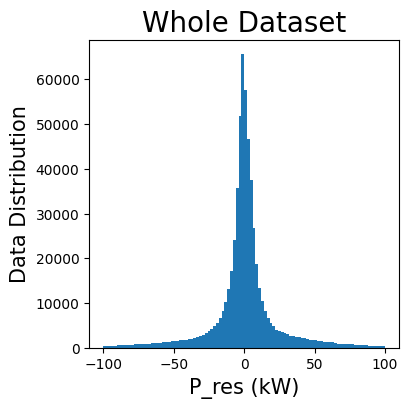

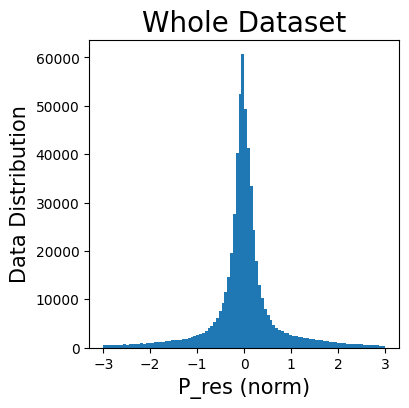

In [15]:
# Plot distribution of P_res in kW
Pres_data = dataset['P_res']
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pres_data/1000, range=[-100, 100], bins=100)
plt.xlabel('P_res (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Normalized Pres
Pres_norm = dataset_norm['P_res']
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pres_norm, range=[-3, 3], bins=100)
plt.xlabel('P_res (norm)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()


In [16]:
# Split the data into training and test sets
train_dataset = dataset_norm.sample(frac=0.8, random_state=10)
test_dataset = dataset_norm.drop(train_dataset.index)

In [17]:
# Split input features from labels/targets

#train_features = train_dataset[['V','theta','W']]
#test_features = test_dataset[['V','theta','W']]

column_list = list(dataset.columns)
print(column_list)
column_list.remove('T')
column_list.remove('P')
column_list.remove('Cp')
column_list.remove('lambda')
column_list.remove('P_phys')
column_list.remove('P_res')
print(column_list)

train_features = train_dataset[column_list[:]]
test_features = test_dataset[column_list[:]]
train_labels = train_dataset.pop('P_res')
test_labels = test_dataset.pop('P_res')

print(train_features.shape)
print(train_labels.shape)
n_inputs = len(column_list)
print('n_inputs: ',n_inputs)

['theta', 'hub_temperature', 'nacelle_angle', 'nacelle_temperature', 'V1', 'V2', 'V', 'Wind_angle', 'Vane_angle', 'Out_temperature', 'grid_frecuency', 'grid_voltage', 'W', 'Rotor_temperature', 'Wind_angle_c', 'nacelle_angle_c', 'T', 'P', 'Cp', 'lambda', 'P_phys', 'P_res']
['theta', 'hub_temperature', 'nacelle_angle', 'nacelle_temperature', 'V1', 'V2', 'V', 'Wind_angle', 'Vane_angle', 'Out_temperature', 'grid_frecuency', 'grid_voltage', 'W', 'Rotor_temperature', 'Wind_angle_c', 'nacelle_angle_c']
(482119, 16)
(482119,)
n_inputs:  16


In [18]:
pred1 = model1.predict(test_features[['V','theta','W']]).flatten()
pred2 = model2.predict(test_features[column_list[:]]).flatten()
pred_12 = pred1 + pred2
pred_12.shape

3767/3767 [==============================] - 2s 435us/step


(120530,)

In [19]:
pred_global = model.predict((test_features[['V','theta','W']],test_features[column_list[:]])).flatten()
pred_global.shape

3767/3767 [==============================] - 2s 487us/step


(120530,)

In [20]:
diff = pred_global - pred_12
print(diff.mean())
print(diff.std())
print(diff.max())

1.3141129e-09
3.8051972e-08
4.7683716e-07
